<a href="https://colab.research.google.com/github/bearylogical/bayesian_mm/blob/main/notebooks/emcee_strain_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Material estimation using bayesian parameter estimation

Note: *Referenced from Nick Jaensson's tutorial on Bayesian Inference, along with all the conventions specified in the tutorial.* 

In this notebook, we will utilise the findings by Wyss et al. (2010) to obtain the Shear ($G$) and Elastic ($K$) modulus from observations of data of a trapped particle in a capillary under applied pressure. The situation is illustrated in the image below where we see that, due to the applied pressure, the particle moves to the left and is deformed in some directions.

<p style="text-align:center;"><img src="../assets/img_a.png" width="200" height="100"></p>

If we simplify the images above, we can get something like below:

<p style="text-align:center;"><img src="../assets/pre_post.png" width="600" height="400"></p>

From the above image, we take image (**A**) to be the reference image. With the application of pressure and some settling time for the particle to remain in its state under the applied pressure, we observe something similar to image (**B**).

To obtain the extent of deformation of the particle, we obtain keypoints from each image. Each experiment consists of a series of images taken at various applied pressures. The keypoints are provided below:

<p style="text-align:center;"><img src="../assets/ref_coords.png" width="600" height="400"></p>

With this information, we can obtain the characteristic dimension $L_\mathrm{band}$ and $R_\mathrm{band}$ throught the various points, *P*.  $L_\mathrm{band}$ the longitudinal length of the portion of the particle in contact with the walls of the capillary while $R_\mathrm{band}$ is the averaged radii of the front and back part of the particle (viewed as a conical frustum with half spheres at both ends)

By having more observations of the R and L bands, we get information on the deformation and, if we assume that the particle deforms isotropically (uniform in all directions), Wyss et al. obtained the following relations for $G$ and $K$.

$$ G = \frac{p_{\mathrm{wall}} - p}{2(\epsilon_r - \epsilon_z)} $$
$$ K = \frac{p_{\mathrm{avg}}}{2\epsilon_r + \epsilon_z} $$

$\epsilon_r$ refers to the change in  $R_\mathrm{band}$ given by : $\epsilon_r = \frac{R_0 - R_n}{R_0}$ where $n$ refers to the subsequent observations after $R_0$ (the first observation). Likewise, $\epsilon_z$ refers to the change in $L_\mathrm{band}$ given by  $\epsilon_z = \frac{L_0 - L_n}{L_0}$. 

Ideally, we assume that we conduct our observations in a highly controlled environment such that we believe that the results that we obtain are close to the actual G and K of the material. However, we know that such a situation is highly unlikely and there can exist other sources of error that can distort the true value. To be able to incorporate such such uncertainties of our results, we can turn to Bayesian Inference (BI). In this case, we are not absolutely certain of the **G** and **K** we have obtained from our experiment. We can view the model parameters **G** and **K** as random variables with an underlying probability distribution function. Subsequently, as seen from the above equation, we also need $p_\mathrm{wall}$ to obtain the G and K, since we cannot actually observe the pressure on the wall, we can also denote it as an uncertain model parameter. The uncertain model parameters can be denoted by $\boldsymbol{m}$ such that:


$$\boldsymbol{m} = \begin{Bmatrix}
G \\
K \\
p_{\mathrm{wall}}
\end{Bmatrix}$$

Our reference image from which we obtain the strains have its own uncertainty around its L and R bands, together with the applied pressure, $P_0$. For a start, we'll assume that we are very certain about them and hence denote them as deterministic model parameters. In practice, to obtain **m** we need to make observations, $\boldsymbol{d}$ of the L and R bands.

$$\boldsymbol{d} = \begin{Bmatrix}
L_\mathrm{band, i} \\
R_\mathrm{band, i} 
\end{Bmatrix}$$

where $i\gt0$

Next, we denote a forward operator $\boldsymbol{g}$ which relates the model parameters and the observables. 

$$\boldsymbol{d} = \boldsymbol{g}(\boldsymbol{m})$$

We will need to invert our $G$ and $K$ relationships in order to obtain our strains such that we end up with our observable R and L band. This will be our forward operator, $\boldsymbol{g}$.

As mentioned previously, our observations can also be corrupted by noise. Hence we can represent as follows:

$$\boldsymbol{y_i} = \boldsymbol{g_i}(\boldsymbol{m}) + \epsilon \quad \text{for } 1 \leq i \leq N$$ 

with $\boldsymbol{y_i}$ being our observed measurables (R and L band), $\boldsymbol{g_i}$ being our forward model including our deterministic parameters which vary depending on $i$ and $\boldsymbol{\epsilon}$ which we assume to be the total noise containing contributions from both the measure noise and the model that, as a starting point is known and additive.  

For this notebook, we will use the value of G and K from Wyss et al. (2010) which are 0.8 kPa and 4.5 kPa respectively.

We first start by importing libraries we will use for this exercise

# Import Libraries

In [204]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import multivariate_normal
import corner
import emcee
import seaborn as sns
np.random.seed(123)
import os
from multiprocessing import Pool

os.environ["OMP_NUM_THREADS"] = "1"


## Defining our forward operator

Given a known G, K and $p_\mathrm{wall}$, we need to find a way to obtain our forward operator $\boldsymbol{g}$.

First we obtain our strains by solving $\epsilon_r$ and $\epsilon_z$ simultaneously:

$$ \begin{bmatrix}
\epsilon_r  \\
\epsilon_z
\end{bmatrix}
 = 
\begin{bmatrix}
1 & -1 \\
2 & 1 
\end{bmatrix}^{-1}
\begin{bmatrix}
\frac{\Delta P}{2 G} \\
\frac{P_\mathrm{avg}}{K}
\end{bmatrix}
$$

with $\Delta P = p_\mathrm{wall} - p_0$ and $P_\mathrm{avg}=\frac{1}{3}(2p_{\mathrm{wall}} + p_0) $

then, with we obtain $L_i$ and $R_i$ by the following: 

$$L_i = L_0 - \epsilon_z L_0 \\ 
  R_i = R_0 - \epsilon_z R_0 $$


In [114]:
# def p_wall(r, l, alpha, p):
#   return (p * (r + 0.5 * l * np.tan(alpha)) ** 2 ) / ( 2 * np.sin(alpha) * r * l * np.sqrt(1+ (np.tan(alpha))**2)) 

def model(G, K, p_wall, r_0=r_0, l_0=l_0, p_0=p_0):
    delta_P = p_wall - p_0
    p_avg =  1/3 * (2 * p_wall + p_0)
    b1 = delta_P / (2 * G)
    b2 = p_avg / (2 * K)
    b = np.hstack([b1, b2]).T
    eps = A_inv.dot(b) #[er, ez]
    if eps.ndim == 1:
        er,ez = eps[0], eps[1]
        r_1 = r_0 - er * r_0
        l_1 = l_0 - ez * l_0
        return r_1, l_1 
    else:
        er, ez = eps[0,:], eps[1,:]
        r_1 = r_0.T - er * r_0.T
        l_1 = l_0.T - ez * l_0.T
        return np.vstack([r_1, l_1]).T

## Test our model function

In [115]:
model(true_G, true_K, true_p_wall, r_0, l_0, p_0)

(95.01413513065441, 390.64183056808895)

# Define our constants and our ground truth

In [10]:
length_scale = 1
# constants
true_G = 9867.9056 / length_scale
true_K = 60776.0301 / length_scale

A = np.array([[1, -1], [2,  1]])
A_inv = np.linalg.inv(A)

p_0 = 11220 / length_scale
true_p_wall = 19946.5733

r_0, l_0 = 117.9 / length_scale , 313.0 / length_scale
alpha = 0.064
rr_1, ll_1 = 95.014/ length_scale , 390.641 / length_scale


## Generate our data

Lets generate some data to obtain some values of $\epsilon_r, \epsilon_z$ and we assume our joint noise $\epsilon$ is Gaussian with a mean of zero and standard deviation, $\sigma_{\mathrm{noise}}$ of 1 (and that is additive).

Since these data are jointly observed, we constract a covariance matrix $\Sigma$ in which we assume that our $L_1$ and $R_1$ are independent (uncorrelated) with a standard deviation of 1. Hence,

$$\Sigma = \begin{bmatrix}
\sigma_{\mathrm{noise}} & 0 \\
0 & \sigma_{\mathrm{noise}} 
\end{bmatrix} $$

In [130]:
N = 120 # number of "observations"
sd_noise = 1

y_err = np.random.normal(loc=0, scale=sd_noise, size=(2, N)) 
y_true = np.array([[rr_1, ll_1]]).T
y = y_true + y_err
cov = np.array([[sd_noise, 0],[0, sd_noise]])

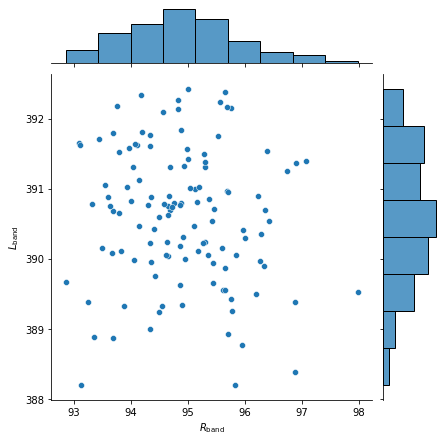

In [131]:
jp = sns.jointplot(x=y[0,:], y=y[1,:])
jp.set_axis_labels(xlabel='$R_{\mathrm{band}}$', ylabel='$L_{\mathrm{band}}$') 
plt.show()

## Bayesian Inference : Details

In this section, we will describe the Bayesian approach in greater detail.

Bayesian inference is an application of Bayes rule where:

$$P(\boldsymbol{m}\mid \boldsymbol{y}) = \frac{P(\boldsymbol{y}\mid \boldsymbol{m})P(\boldsymbol{m})}{P(\boldsymbol y)}$$

In this way, we can obtain the probability of our model parameters, $\boldsymbol{m}$ given some observations $\boldsymbol{y}$.

Note that for multiple observations of $\boldsymbol{y}_1, \boldsymbol{y}_2, \boldsymbol{y}_3, \dots, \boldsymbol{y}_N$ we denote those observations as $\boldsymbol{y}$ which is applicable to all terms containing $\boldsymbol{y}_1$ in the Bayes' formulation above.

We then use the following conventions to denote the terms of the Bayes' rule:

- $P(\boldsymbol{m}\mid \boldsymbol{y})$ : Posterior probability
- $P(\boldsymbol{y}\mid \boldsymbol{m})$ : Likelihood
- $P(\boldsymbol{m})$ : Prior - This is where we encode our knowledge of our materials i.e Values G and K can take. 
- $P(\boldsymbol y)$ : Evidence



# Define our Priors

What does it mean to "encode our knowledge?" Supposing that we have an inklking that G (for this batch of synthesized microgels) should be between 8kPa and 11kPa. To make this more concrete, we also know that from our previous experiments, the value of G is around 10kPa.

From this information, we know that at 10kPa, the probability that that value is close to the true value of G is the highest, with a standard deviation of 1kPa. This allows us to represent this bit if information as a Gaussian distribution as $G\sim N (10000, 1000)$ and formalised as:

$$ p(G) = \frac{1}{\sqrt{2\pi}\sigma_{\mathrm{prior}}} \exp \Big( -\frac{(G-\bar{G}_{\mathrm{prior}})^2}{2\sigma^2_{\mathrm{prior}}}\Big)$$

This is similar to our $K$ where we can denote this by $K\sim N(60000, 5000)$. Note that we are less certain on our K, thus we adjust our $\sigma_{K}$ accordingly.

As for the $p_{\mathrm{wall}}$. we will represent this with a flat (uniform) prior where we assign equal probability to all the values within the range such that $17 kPa \leq p_{\mathrm{wall}} \leq 20kPa$.

A flat prior is defined as: 

$$ p(x) = \begin{cases}
        \frac{1}{b-a} & for \quad x\in[a,b] \\
        0 & otherwise \\
    \end{cases}$$

We can illustrate the probability distribution of G like below:



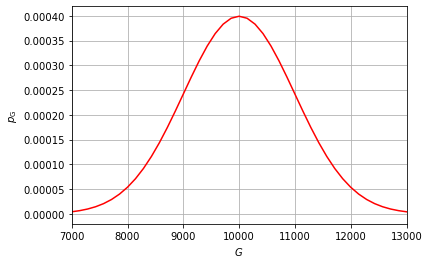

In [184]:
mean_prior = 1e4  # mean modulus for the prior
sd_prior = 1e3  # standard deviation (SD) for the prior
gplot = np.linspace(7e3, 14e3, 50)

def gaussian_prior(x, loc, scale):
    return np.exp(-(x-loc)**2/(2*scale**2)) / (scale*np.sqrt(2*np.pi))

plt.plot(gplot,gaussian_prior(gplot,mean_prior,sd_prior),c='r') 
plt.xlim([7e3, 13e3])
plt.xlabel("$G$")
plt.ylabel("$p_{\mathrm{G}}$")
plt.grid()
plt.show()

And we do something similar to show what our $p_{\mathrm{wall}}$ flat prior looks like.

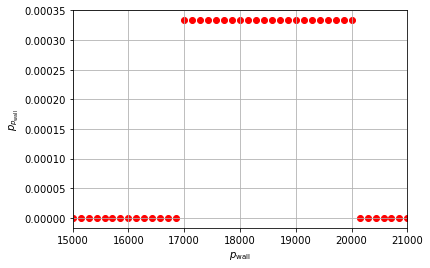

In [188]:
pwall_plot = np.linspace(1.5e4, 2.2e4, 50)

uniform_a = 1.7e4
uniform_b = 2e4
def uniform_prior(x, a, b):
    res = np.zeros(x.shape)
    res[(x<=b) & (x>=a)] = 1 / (b-a) 
    return res      

plt.scatter(pwall_plot,uniform_prior(pwall_plot,uniform_a,uniform_b),c='r') 
plt.xlim([1.5e4, 2.1e4])
plt.xlabel("$p_{\mathrm{wall}}$")
plt.ylabel("$p_{p_{\mathrm{wall}}}$")
plt.grid()
plt.show()

We encode all these priors as below. Note that we represent all our priors as log priors such that we can sum up the log of each prior probability for a given parameters' respective distribution. Note that the uniform prior overides all other priors as it is only 0 within the range while $-\infty$ otherwise, This means that anything summed with $-\infty$ is $-\infty$ ultimately.

In [198]:
def log_prior(theta):
    G, K, p_wall = theta
    if not 1.7e4 < p_wall < 2.2e4:
        return -np.inf
    else:
        p_G = np.log(gaussian_prior(G, loc=1e4, scale=1e3))
        p_K = np.log(gaussian_prior(K, loc=6e4, scale=5e3))
        return p_G + p_K
    # if 8e3 < G < 1.1e4 and 6e4 < K < 7e4 and 1.1e4 < p_wall < 2.1e4:
    #     return 0.0 # ln(1) = 0
    # return -np.inf


# Define our likelihood

First, we define our likelihood $P(\boldsymbol{y}\mid \boldsymbol{m})$ using the multivariate log likelihood as we obtain both values jointly. 
We use the log multivariate formulation and dropping constant terms. 

$$\ln L(y) = - \frac{1}{2}\Big[(y - \boldsymbol{g}(\boldsymbol{m}))^T \Sigma^{-1} (y- \boldsymbol{g}(\boldsymbol{m}))\Big]$$ 

$\Sigma$ is the covariance matrix with $\sigma_{\mathrm{noise}}$ along its diagonals and uncorrelated, as defined at the start.

In [210]:
def log_likelihood(theta, x, y, cov):
    G, K, p_wall = theta 
    r_0, l_0, p_0 = np.hsplit(x, 3)  # unpack our data
    y_pred = model(G, K, p_wall, r_0, l_0, p_0)
    res = y - y_pred
    def calc_loglikelihood(res):
        return -0.5 * np.dot(res, np.linalg.solve(cov, res))
    loglikelihood = np.apply_along_axis(calc_loglikelihood, 1, res)
    return loglikelihood.sum()

# Obtain the MLE of the log likelihood

In [200]:
# solve via MLE
from scipy.optimize import minimize

x = np.array((r_0, l_0, p_0)) + 0.1 + np.random.randn(3, N).T
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_G, true_K, true_p_wall]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y.T, cov))
G_ml, K_ml, p_wall_ml = soln.x

print("Maximum likelihood estimates:")
print(f"G = {G_ml:.3f}")
print(f"K = {K_ml:.3f}")
print(f"p_wall = {p_wall_ml:.3f}")

Maximum likelihood estimates:
G = 10612.410
K = 60130.380
p_wall = 20640.045


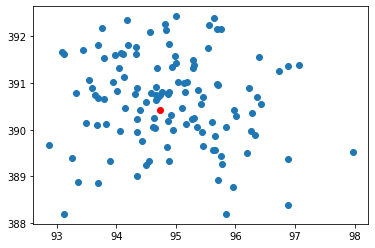

In [201]:
pred = model(G_ml, K_ml, p_wall_ml, r_0, l_0, p_0)
plt.scatter(y[0,:], y[1,:])
plt.scatter(x=pred[0], y=pred[1], c='red')

We see that the MLE value lies right in the middle of our points

# Define our posterior function


Our Posterior Probability is explicitly stated as:
$$ P(G, K \mid r_0, l_0, r_1, l_1, p) \propto P(r_1, l_1, G, K, p_{\mathrm{wall}})P(r_1, l_1 | G, K, r_0, l_0, \alpha, p, p_{\mathrm{wall}})$$

Because we are taking the log of the posterior, we can formulate the posterior as a sum of the (log) prior and the (log) likelihood.

In [202]:
def log_probability(theta, x, y, cov):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, cov)

Use `emcee` to sample from our posterior

`emcee` needs somewhere to start. We use the MLE result as a starting point for the random walk.

In [203]:


pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y.T, cov)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [04:07<00:00, 20.17it/s]


## Model Diagnostics

In this section we visualise the results of the sampling procedure to get some view of the stability of the chain samples.

In [205]:
import matplotlib.pyplot as plt

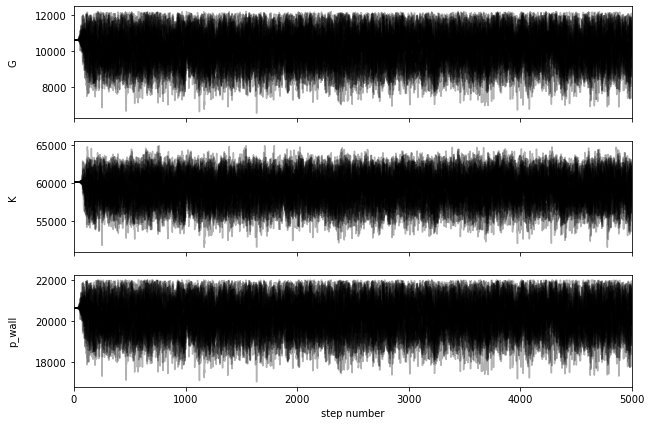

In [206]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["G", "K", "p_wall"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [207]:
tau = sampler.get_autocorr_time()
print(tau)

[36.79860026 36.29450389 36.9080076 ]


In [208]:
flat_samples = sampler.get_chain(discard=1000, thin=25, flat=True)
print(flat_samples.shape)

(5120, 3)


# Results

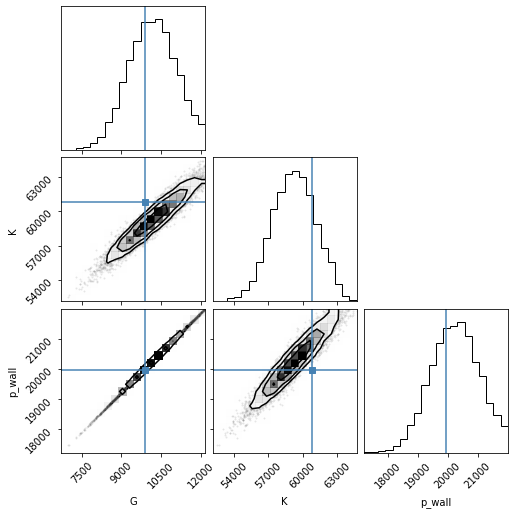

In [209]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_G, true_K, true_p_wall]
);

## TODO:

1. Visualise results of L1, R1 from our uncertinaty of G and K
2. Effect of data 
3. Effect of prior